In [1]:
#!/usr/bin/env python3
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import astropy.units as u
from sunpy.time import TimeRange
import time
import sys

import datetime as dt
import matplotlib.dates as mdates
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib import gridspec,transforms

%matplotlib inline

In [2]:
sys.path.insert(1, '../../20201013_jupiter/')
from sk import LofarRaw


#rcParams['agg.path.chunksize'] = 10000

In [3]:
mpl.use('nbagg')
import matplotlib.pyplot as plt

In [4]:
import matplotlib.backends
import os.path

def is_backend_module(fname):
    """Identifies if a filename is a matplotlib backend module"""
    return fname.startswith('backend_') and fname.endswith('.py')

def backend_fname_formatter(fname): 
    """Removes the extension of the given filename, then takes away the leading 'backend_'."""
    return os.path.splitext(fname)[0][8:]

# get the directory where the backends live
backends_dir = os.path.dirname(matplotlib.backends.__file__)

# filter all files in that directory to identify all files which provide a backend
backend_fnames = filter(is_backend_module, os.listdir(backends_dir))

backends = [backend_fname_formatter(fname) for fname in backend_fnames]

print(backends)

['mixed', 'webagg', 'gtk3', 'pgf', 'ps', 'wxcairo', 'tkagg', 'gtk3agg', 'wx', 'macosx', 'wxagg', 'qt4cairo', 'qt5cairo', 'tkcairo', 'qt5agg', 'gtk3cairo', 'agg', 'qt5', 'cairo', 'qt4', 'nbagg', 'pdf', 'webagg_core', 'svg', 'qt4agg', 'template']


In [5]:
filename = '../udpoutput/uranus-stokesVectors_0_2020-12-15T20:04:00_19629670898060' #0 is I and 1 is V I assume
frange = [15,30]
sbs = np.arange(76,198)
obs_mode = 3
time_len_mins = 176.
trange = TimeRange(filename.split('_')[-2], time_len_mins*u.min)
xlabel = "Time from {} {}".format(filename.split('_')[-2].split('T')[0], filename.split('_')[-2].split('T')[1])
ylabel = "Frequency (MHz)"
title = filename.split('/')[2]

In [6]:
off_fname = '../udpoutput/offsource-stokesVectors_0_2020-12-15T20:04:00_19629670898060'
#trange is the same for both beams
#time_len_mins = 176.
#offtrange = TimeRange(off_fname.split('_')[-2], time_len_mins*u.min)
#offxlabel = "Time from {} {}".format(off_fname.split('_')[-2].split('T')[0], off_fname.split('_')[-2].split('T')[1])
#offylabel = "Frequency (MHz)"
#offtitle = off_fname.split('/')[2]

In [7]:
# read in the data (stokes I or V from udpPM)
raw = LofarRaw(fname=filename, sbs=sbs, obs_mode=obs_mode, frange=frange)
raw.data = raw.data[:,:78] ###the rest of the subbands are empty because of the way ilofar/realta records data into the data lanes
offraw = LofarRaw(fname=off_fname, sbs=sbs, obs_mode=obs_mode, frange=frange)
offraw.data = offraw.data[:,:78]

Time to read data: 0.000872s

Time to read data: 0.000158s



In [8]:
flimits = np.array([0,78])
freqlimits = raw.sb_to_f(flimits+sbs[0], obs_mode)
xlims = list(map(dt.datetime.fromisoformat, [trange.start.value, trange.end.value]))
xlims = mdates.date2num(xlims)

In [9]:
datasplit = 10
normseconds = 42
norm_splits = int(((trange.minutes.value/datasplit)*60)/normseconds)

tchunks = trange.split(datasplit)
datas = np.array_split(raw.data, datasplit, axis=0)
offdatas = np.array_split(offraw.data, datasplit, axis=0)

In [19]:
smooth_offs = []
for i,j in enumerate(offdatas):
    arrs = np.array_split(j, norm_splits)
    for arr in arrs:
        for i in np.arange(arr.shape[1]):
            if np.any(np.isnan(arr[:,i])):
                pass
            else:
                coeffs = np.polyfit(np.linspace(0, len(arr[:,i]), len(arr[:, i])), arr[:, i], 2)
                ynew = np.poly1d(coeffs)
                arr[:, i] = ynew(np.linspace(0, len(arr[:, i]), len(arr[:, i])))
    smooth_offs.append(np.vstack(arrs))
smooth_off = np.vstack(smooth_offs)

In [21]:
smooth_off.shape

(128906263, 78)

In [ ]:
arrs = np.array_split(offdatas, norm_splits)
for arr in arrs:
    for i in np.arange(arr.shape[1]):
        if np.any(np.isnan(arr[:,i])):
            pass
        else:
            coeffs = np.polyfit(np.linspace(0, len(arr[:,i]), len(arr[:, i])), arr[:, i], 2)
            ynew = np.poly1d(coeffs)
            arr[:, i] = ynew(np.linspace(0, len(arr[:, i]), len(arr[:, i])))
datas = np.vstack(arrs)

In [9]:
def plot_data(data, trange, flims, xlabel, ylabel, plotname):
    f = plt.figure(figsize=(12,6))
    f.set_facecolor('white')

    spec = gridspec.GridSpec(ncols=2, nrows=2, width_ratios=[6,1], height_ratios=[1,4])
    ax0 = f.add_subplot(spec[0])
    ax2 = f.add_subplot(spec[2])
    ax3 = f.add_subplot(spec[3])

    xs = data.T.sum(axis=0)
    ys = data.T.sum(axis=1)

    ax0.plot(xs, lw=0.5)
    ax0.set(xticklabels=[], xlim=[0,None])
    ax0.tick_params(bottom=False)

    rot = transforms.Affine2D().rotate_deg(270)
    ax3.plot(ys[::-1], lw=0.5, transform=rot+plt.gca().transData)
    ax3.set(yticklabels=[])
    ax3.tick_params(left=False)

    xlims = list(map(dt.datetime.fromisoformat, [trange.start.value, trange.end.value]))
    xlims = mdates.date2num(xlims)

    im = ax2.imshow(data.T, aspect='auto', origin='lower',
            vmin=np.nanpercentile(data.T, 5), 
            vmax=np.nanpercentile(data.T, 90),
            extent=[xlims[0], xlims[1], 
                    flims[0].value, flims[1].value])

    ax2.xaxis_date()
    date_format = mdates.DateFormatter('%H:%M:%S')
    ax2.xaxis.set_major_formatter(date_format)

    ax2.set_title("Uranus observation - Stokes I")
    ax2.set_ylabel(ylabel, fontsize=14)
    ax2.set_xlabel(xlabel, fontsize=14)

    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="3%", pad=0.05)
    plt.colorbar(im, cax=cax)

    plt.tight_layout()
    plt.savefig(plotname, dpi=900)

In [45]:
for i,j in enumerate(datas):
    print("Analysing chunk #{} of data".format(i+1))

    bg = np.true_divide(j, offdatas[i], out=np.zeros_like(j), where=offdatas[i]!=0) #bg removal... (?) I think

    #dec = 256
    #dec = 3662 # dec = 3662 gives a resolution of 150 ms
    #summed = np.cumsum(bg, axis=0)
    #dec_data = summed[dec::dec, :] - summed[:-dec:dec, :]
    dec = 1831
    pad = np.ceil(float(bg.shape[0])/dec)*dec - bg.shape[0]
    pad_arr = np.zeros((int(pad), bg.shape[1]))*np.NaN
    bg_padded = np.append(bg, pad_arr).reshape(-1, bg.shape[1])
    dec_data = np.nanmean(bg_padded.T.reshape(bg.shape[1], -1, dec), axis=2).T
    
    #print('\tData downsampled x{}'.format(int(dec/2)))
    print('\tData downsampled x{}'.format(int(dec)))
    print('\t Data shape: {}'.format(dec_data.shape))

    print("\tPlotting...\n")
    plot_data(dec_data, tchunks[i], freqlimits, xlabel, ylabel, 'bg_removal_with_off_stokesI/Uranus_remove_bg_{}'.format(i+1))

Analysing chunk #1 of data
(12892071, 78)
	Data downsampled x1831
	 Data shape: (7041, 78)
	Plotting...

Analysing chunk #2 of data
(12892071, 78)
	Data downsampled x1831
	 Data shape: (7041, 78)
	Plotting...

Analysing chunk #3 of data
(12892071, 78)
	Data downsampled x1831
	 Data shape: (7041, 78)
	Plotting...

Analysing chunk #4 of data
(12892071, 78)
	Data downsampled x1831
	 Data shape: (7041, 78)
	Plotting...

Analysing chunk #5 of data
(12892071, 78)
	Data downsampled x1831
	 Data shape: (7041, 78)
	Plotting...

Analysing chunk #6 of data
(12892071, 78)
	Data downsampled x1831
	 Data shape: (7041, 78)
	Plotting...

Analysing chunk #7 of data
(12892071, 78)
	Data downsampled x1831
	 Data shape: (7041, 78)
	Plotting...

Analysing chunk #8 of data
(12892071, 78)
	Data downsampled x1831
	 Data shape: (7041, 78)
	Plotting...

Analysing chunk #9 of data
(12892071, 78)
	Data downsampled x1831
	 Data shape: (7041, 78)
	Plotting...

Analysing chunk #10 of data
(12892071, 78)
	Data downsa

In [9]:
bg = raw.data
dec = 732421 #1 minute resolution
pad = np.ceil(float(bg.shape[0])/dec)*dec - bg.shape[0]
pad_arr = np.zeros((int(pad), bg.shape[1]))*np.NaN
bg_padded = np.append(bg, pad_arr).reshape(-1, bg.shape[1])
dec_data = np.nanmean(bg_padded.T.reshape(bg.shape[1], -1, dec), axis=2).T


In [10]:
bg = offraw.data
dec = 732421 #1 minute resolution
pad = np.ceil(float(bg.shape[0])/dec)*dec - bg.shape[0]
pad_arr = np.zeros((int(pad), bg.shape[1]))*np.NaN
bg_padded = np.append(bg, pad_arr).reshape(-1, bg.shape[1])
dec_offdata = np.nanmean(bg_padded.T.reshape(bg.shape[1], -1, dec), axis=2).T

In [11]:
dec_data.shape

(177, 78)

In [11]:
int_data = np.trapz(dec_data, axis=-1)

In [12]:
int_offdata = np.trapz(dec_offdata, axis=-1)

In [13]:
int_data.shape

(177,)

In [14]:
%matplotlib inline

Text(0.5, 0, 'Time (minutes)')

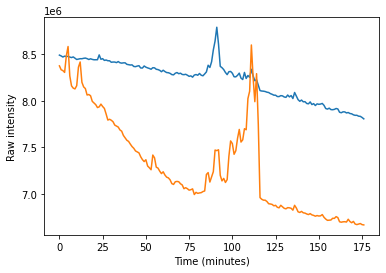

In [15]:
plt.plot(int_data)
plt.plot(int_offdata)
plt.ylabel('Raw intensity')
plt.xlabel("Time (minutes)")